In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# import Wisconsin Breast Cancer dataset

df = pd.read_csv('../capstone1/clean_wisconsin_breast_cancer.csv')
df.head(5)

,thickness,size,shape,adhesion,single,nuclei,chromatin,nucleoli,mitosis,Outcome
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0


In [3]:
df.shape

(683, 10)

In [4]:
# check sum of row nulls
df.isnull().sum()

thickness    0
size         0
shape        0
adhesion     0
single       0
nuclei       0
chromatin    0
nucleoli     0
mitosis      0
Outcome      0
dtype: int64

In [5]:
df.dtypes

thickness      int64
size           int64
shape          int64
adhesion       int64
single         int64
nuclei       float64
chromatin      int64
nucleoli       int64
mitosis        int64
Outcome        int64
dtype: object

In [6]:
# check target values
df.Outcome.value_counts()

0    444
1    239
Name: Outcome, dtype: int64

In [7]:
# define x and y arrays

x = df.drop(['Outcome'],axis=1)
y = df['Outcome']

In [8]:
# train/test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
x,y,
test_size=0.2,    # splitted - 80% (train), 20%(test)
random_state=42)

In [9]:
print(x_train[0:1])

     thickness  size  shape  adhesion  single  nuclei  chromatin  nucleoli  \
437          3     1      1         3       2     1.0          1         1   

     mitosis  
437        1  


In [10]:
print(y_train[0:1])

437    0
Name: Outcome, dtype: int64


In [11]:
# use XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train,y_train)

[16:25:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
y_pred = xgb.predict(x_test)
preds = [round(value) for value in y_pred]
print(y_pred[0:3])

[1 1 0]


In [13]:
print(preds[0:3])

[1, 1, 0]


In [14]:
#  Default XGBoost Classifier report accuracy 

accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy*100.0))

Accuracy: 95.62%


In [15]:
# Report

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[78  1]
 [ 5 53]]


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96        79
           1       0.98      0.91      0.95        58

    accuracy                           0.96       137
   macro avg       0.96      0.95      0.95       137
weighted avg       0.96      0.96      0.96       137



In [17]:
# save model

pickle.dump(xgb, open('../capstone1/wisconsin_xgb_model.pkl', 'wb'))

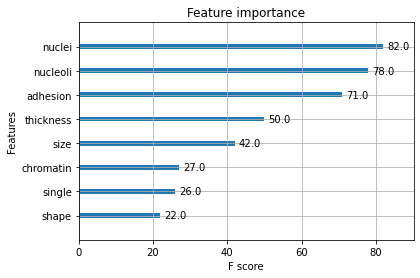

In [18]:
# feature importance

from xgboost import plot_importance
from matplotlib import pyplot as plt
plot_importance(xgb)
plt.show()

In [19]:
# parameter tuning
# xgboost gridsearch

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# parameter grid
gbm_param_grid = {
    'colsample_bytree': [0.3,0.7], # max value is 1.0
    'n_estimators': [50],
    'max_depth': [2,5]
}

In [20]:
# instantiate regressor

gbm = XGBRegressor()

grid_mse = GridSearchCV(param_grid = gbm_param_grid,
                       estimator=gbm)

In [21]:
# optimize by RMSE
# fit grid_rmse to data

grid_mse.fit(x_train,y_train)
print('Best parameter found:', grid_mse.best_params_)
print('Lowest RMSE found:', np.sqrt(np.abs(grid_mse.best_score_)))


Best parameter found: {'colsample_bytree': 0.3, 'max_depth': 2, 'n_estimators': 50}
Lowest RMSE found: 0.9260081693073566


In [22]:
# use optimized parameters

opt_xgb = XGBRegressor(colsample_bytree=0.3, max_depth=2, n_estimators=50)

In [23]:
opt_xgb.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [24]:
# predict the test set

y_pred_opt = opt_xgb.predict(x_test)
preds_opt = [round(value) for value in y_pred_opt]
print(y_pred_opt[0:3])

[ 1.0082395   1.0315092  -0.01498115]


In [25]:
y_pred_opt = [1 if n>=0.5 else 0 for n in y_pred_opt]
print(y_pred_opt[0:3]) #list

[1, 1, 0]


In [26]:
# report accuracy decresed by 1%
# default (95%) is greater than optimization


# Answer by Dr.Rais (Possible causes)
# this data is very good to model 
# check parameters & score
# data is small, grid search not perfect
# may caused by n_estimators, try & error the number(50,100,150)

accuracy_opt = accuracy_score(y_test,y_pred_opt)
print("Accuracy: %.2f%%" % (accuracy_opt*100.0))

Accuracy: 94.16%
